[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.



In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langchain_groq

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [5]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatGroq(model="openai/gpt-oss-120b",
               api_key = os.getenv("GROQ_API_KEY"))
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

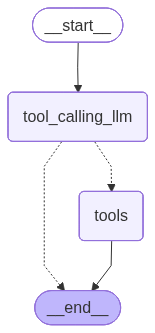

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================

2 multiplied by 2 equals **4**.


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

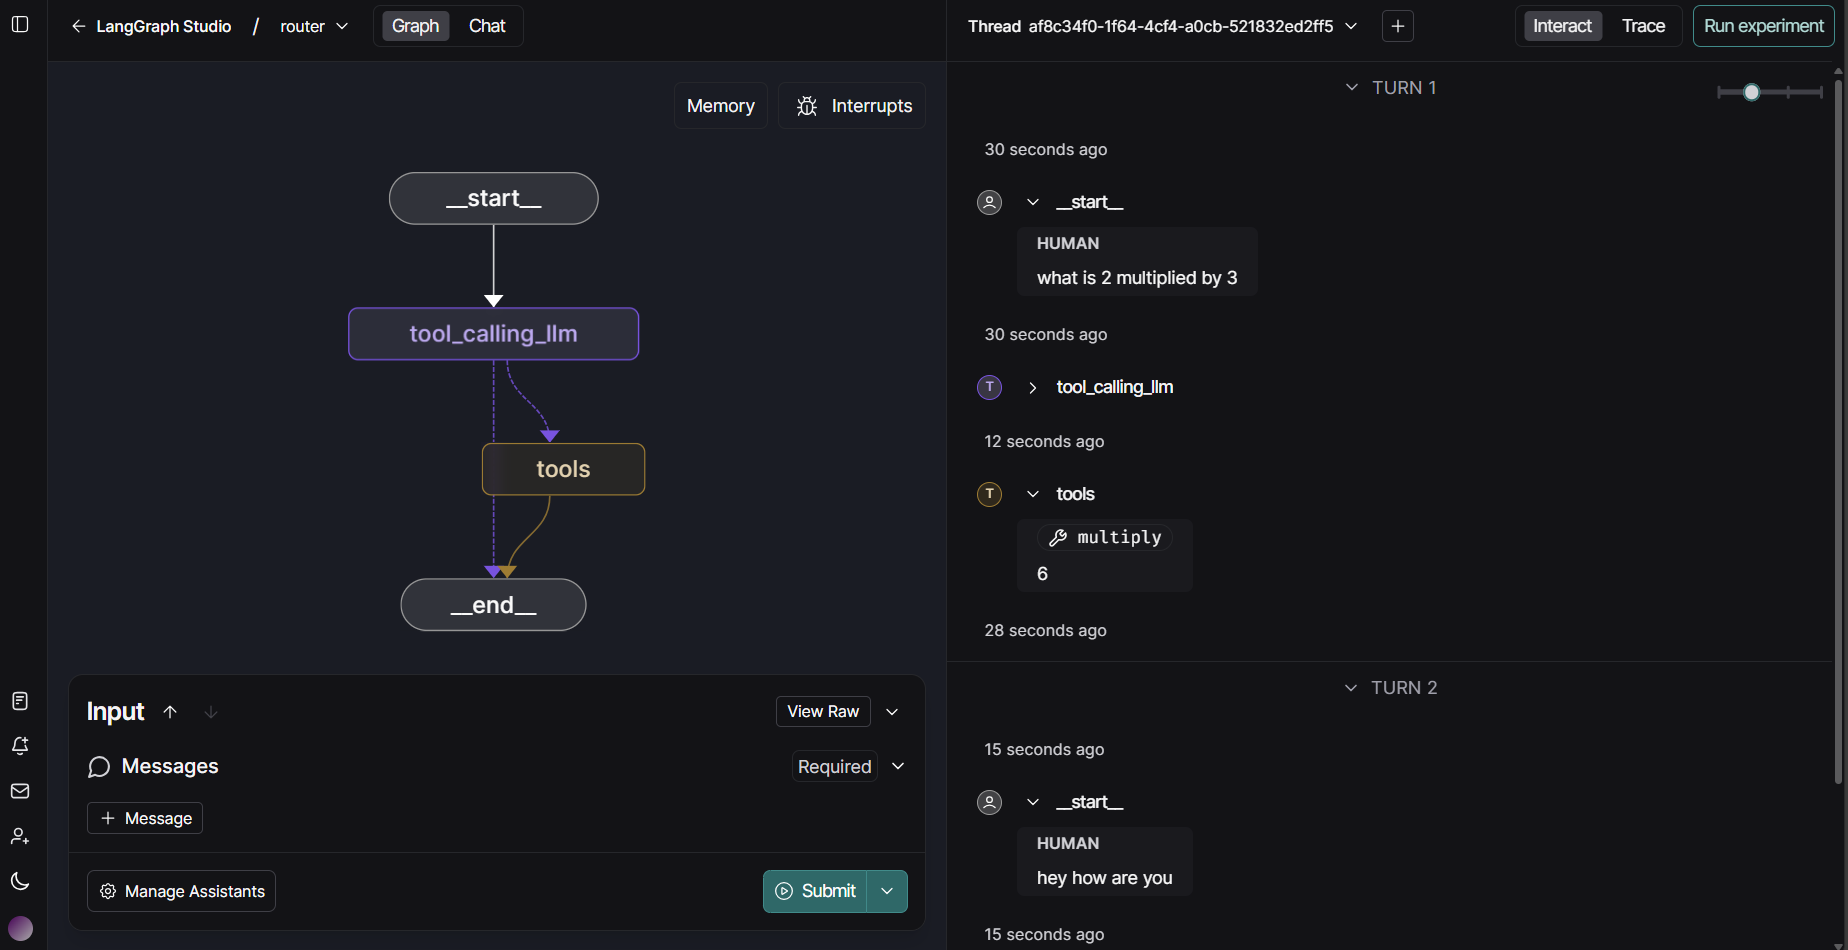

# MY EXAMPLE

Implement a new tool in the existing LangChain graph, update the graph to include the new tool, and test the new router with a human message that requires the new tool.

In [9]:
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [11]:
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    # Handle division by zero
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [10]:
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

## Update the language model with the new tools

### Subtask:
Bind all the defined tools to the language model.

In [12]:
llm_with_tools = llm.bind_tools([multiply, add, subtract, divide])

Construct the router Graph:

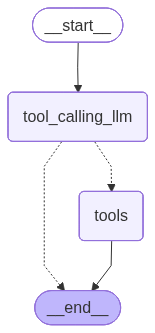

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build new graph with all tools
builder_new = StateGraph(MessagesState)
builder_new.add_node("tool_calling_llm", tool_calling_llm)
builder_new.add_node("tools", ToolNode([multiply, add, subtract, divide])) # Updated to include new tools
builder_new.add_edge(START, "tool_calling_llm")
builder_new.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder_new.add_edge("tools", END)
graph_new = builder_new.compile()

# View
display(Image(graph_new.get_graph().draw_mermaid_png()))

Test it out:

In [17]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is 5 plus 7?")]
messages = graph_new.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 7?
================================== Ai Message ==================================
Tool Calls:
  add (fc_f3f65c67-4674-496a-89f3-dd82e1f9c6b8)
 Call ID: fc_f3f65c67-4674-496a-89f3-dd82e1f9c6b8
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12


In [15]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is 10 divided by 2?")]
messages = graph_new.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 10 divided by 2?
================================== Ai Message ==================================
Tool Calls:
  divide (fc_bd78a9ce-29a1-49fa-8325-2542e1de9828)
 Call ID: fc_bd78a9ce-29a1-49fa-8325-2542e1de9828
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0


*LangGraph Studio:*

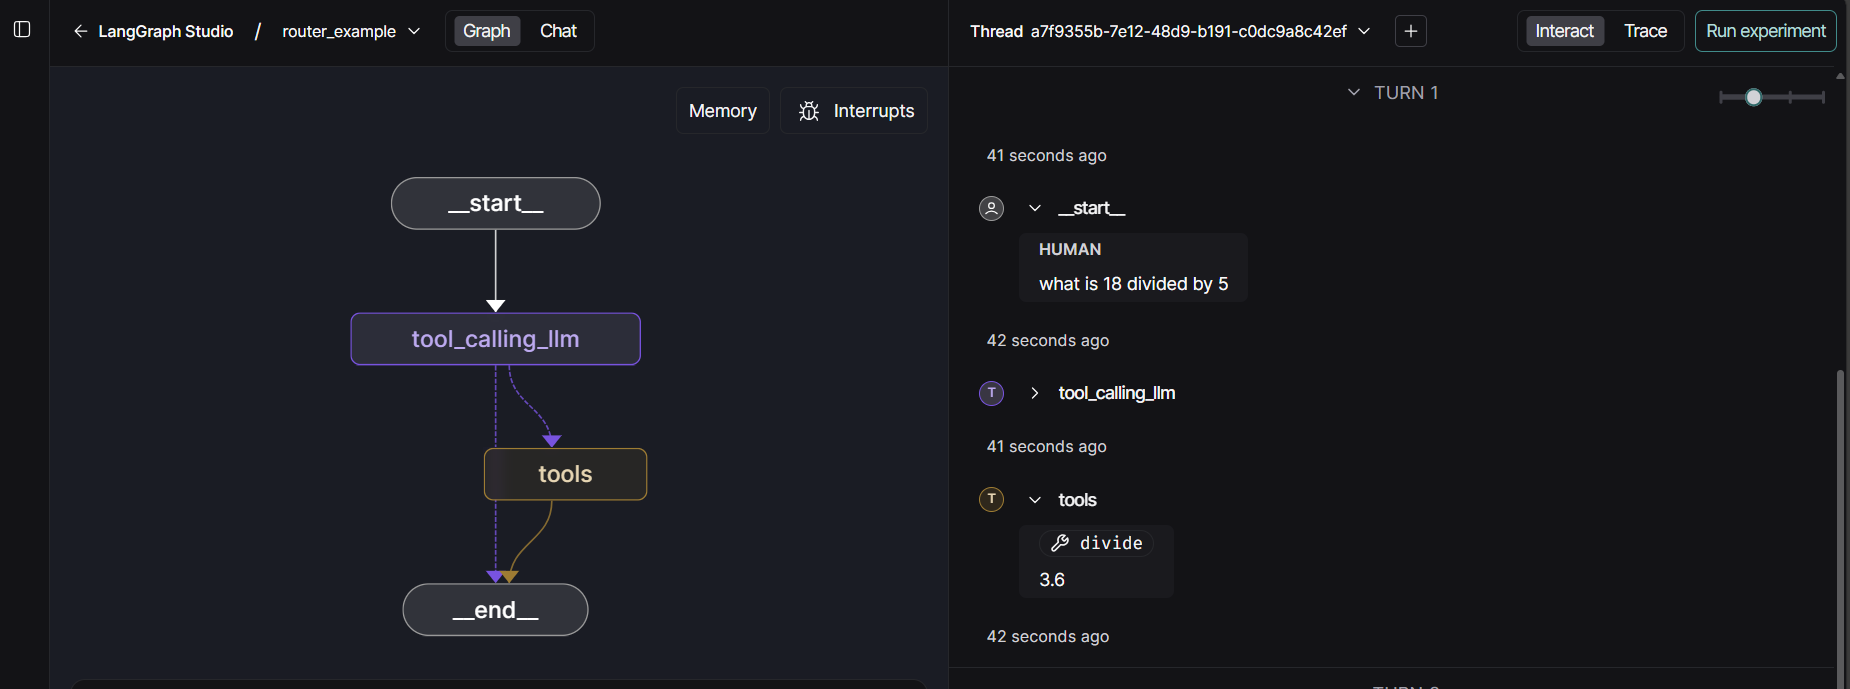

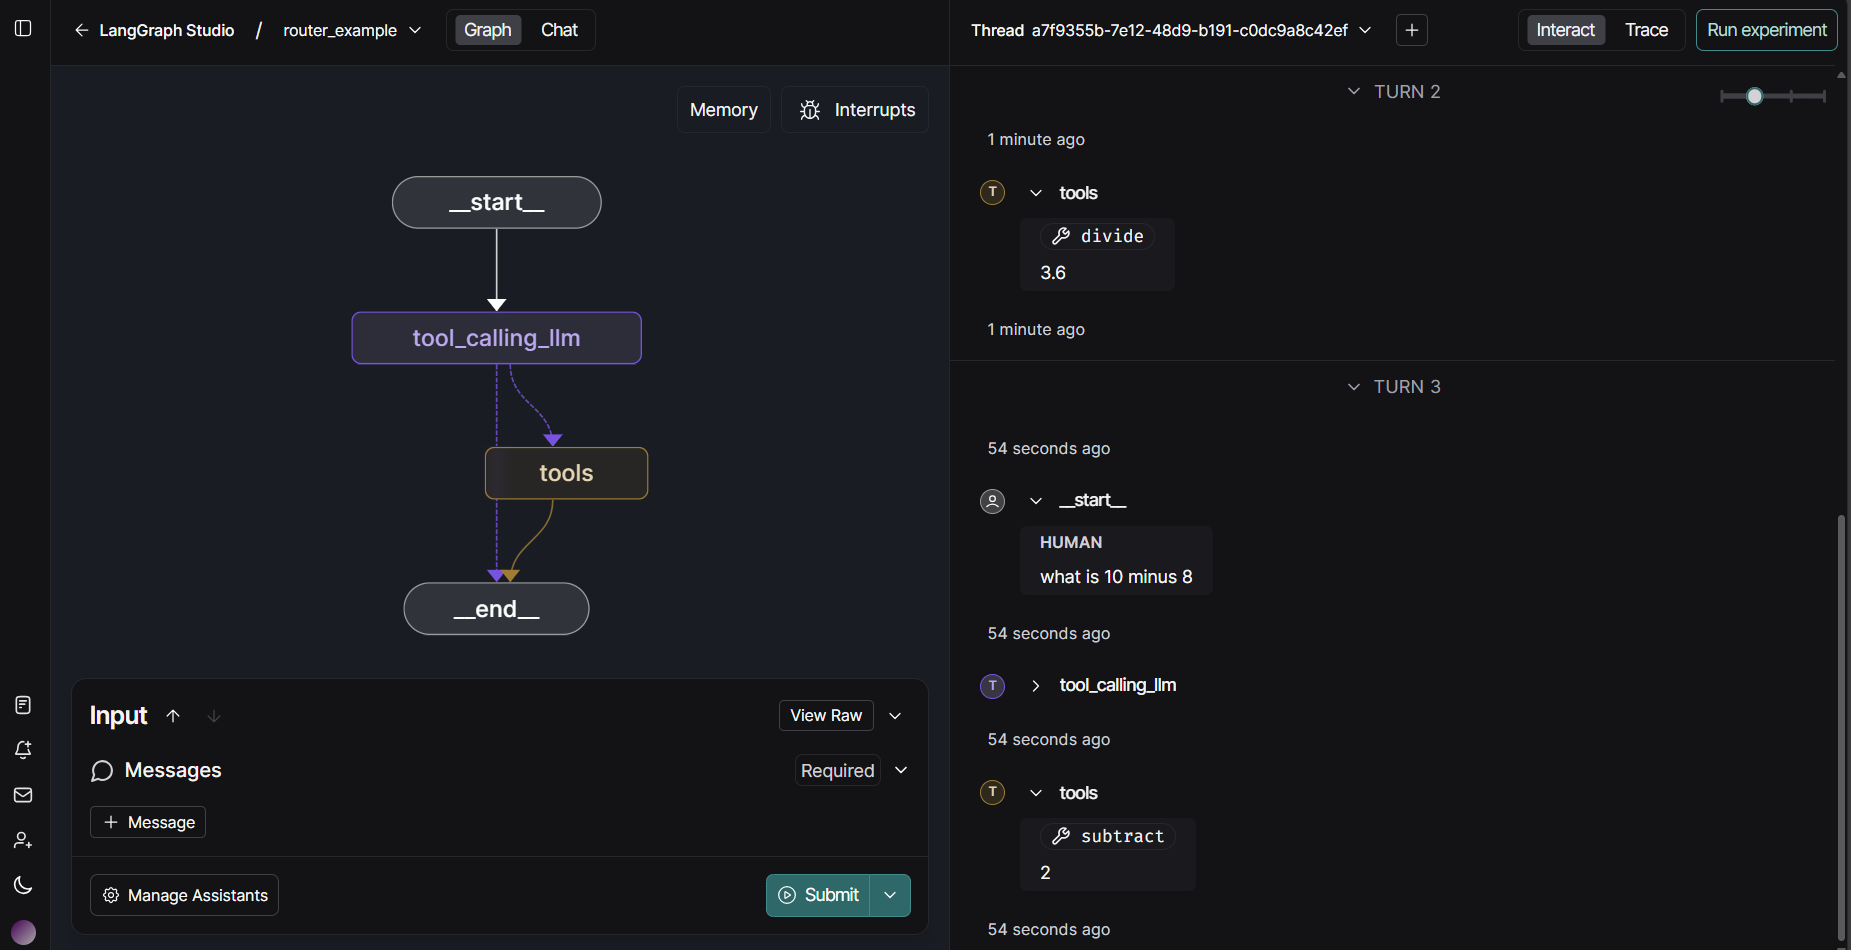